In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../..'))

if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
import pandas as pd
from collections import defaultdict

In [3]:
import warnings 

warnings.filterwarnings('ignore')

# <center>Computational Mathematics Report Experiments</center>
## <center>Support Vector Classifier</center>
### <center>Donato Meoli</center>
##### <center>d.meoli@studenti.unipi.it</center>

<center>Computational Mathematics course 646AA</center>
<center>Academic year: 2019/2020</center>

<center>Type of project: Wildcard #5 with Machine Learning</center>
<center>Group 35</center>

In [4]:
def filter_svc_cv_results(cv_results):
    
    filtered_cv_results = pd.DataFrame()
    
    if 'param_optimizer' in cv_results.columns:
        
        filtered_cv_results['solver'] = cv_results['param_optimizer']
    
    if 'param_fit_intercept' in cv_results.columns:
        
        filtered_cv_results['dual'] = cv_results['param_fit_intercept']
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(True, 'qp')
        filtered_cv_results['dual'] = filtered_cv_results['dual'].replace(False, 'bcqp')
    
    if 'param_kernel' in cv_results.columns:
        
        filtered_cv_results['kernel'] = cv_results['param_kernel']
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*PolyKernel.*$)', 'poly')
        filtered_cv_results['kernel'] = filtered_cv_results['kernel'].astype(str).str.replace(r'(^.*GaussianKernel.*$)', 'rbf')
    
    filtered_cv_results[['C', 'fit_time', 'accuracy', 'n_iter']] = cv_results[[
        'param_C', 'mean_fit_time', 'mean_train_accuracy', 'mean_train_n_iter']]
    
    filtered_cv_results['n_iter'] = filtered_cv_results['n_iter'].round().astype(int)

    filtered_cv_results['n_sv'] = cv_results['mean_train_n_sv'].round().astype(int)

    return filtered_cv_results

In [5]:
from optiml.ml.utils import generate_linearly_separable_overlap_data, generate_nonlinearly_separable_data

lin_X, lin_y = generate_linearly_separable_overlap_data(random_state=123456)
nonlin_X, nonlin_y = generate_nonlinearly_separable_data(random_state=123456)

## Hinge loss

### Primal formulation

In [6]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import hinge
from optiml.ml.utils import plot_svm_hyperplane, plot_model_loss

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [7]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history'):
        train_loss_history[svc.momentum_type][svc.C] = svc.train_loss_history
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits


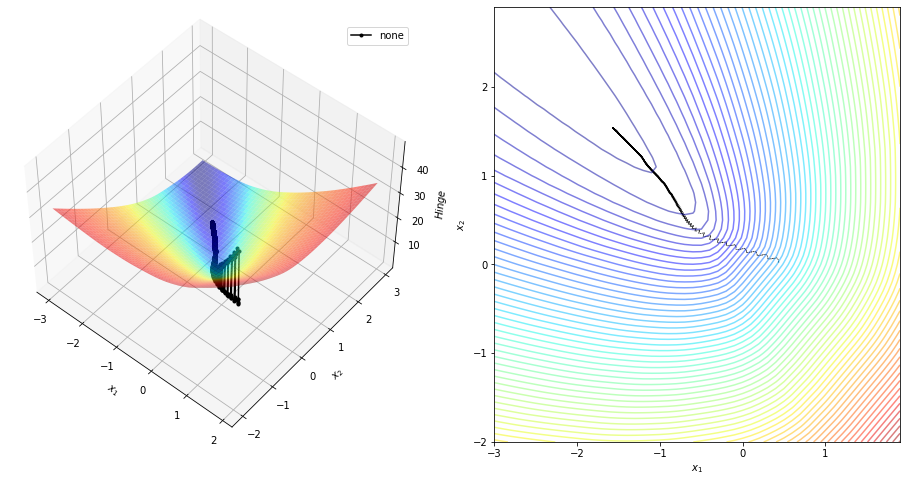

In [8]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
hinge_loss_opt = plot_trajectory_optimization(hinge_loss, grid.best_estimator_.optimizer, color='k', label='none')

In [9]:
none_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.399575     0.970     314    53
                10   0.480145     0.985     384    19
                100  0.258918     0.980     207    10

Fitting 1 folds for each of 3 candidates, totalling 3 fits


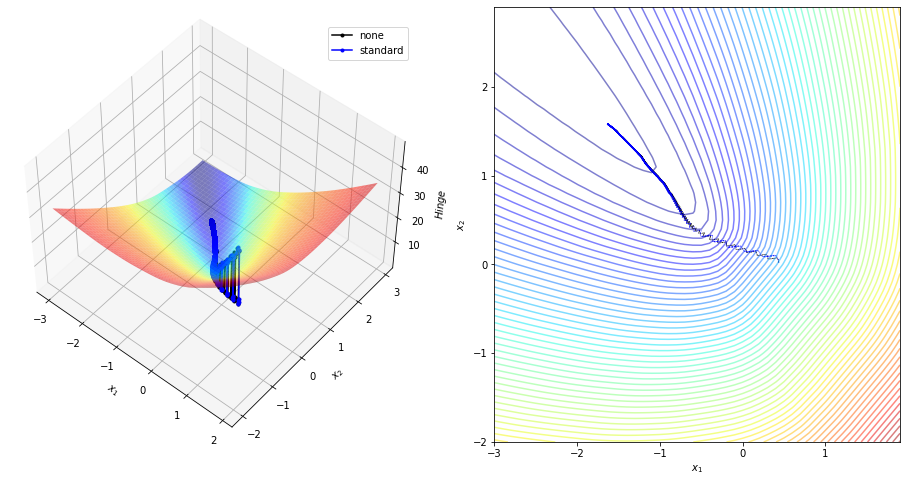

In [10]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='standard', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='b', label='standard')
hinge_loss_opt

In [11]:
standard_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_hinge_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
standard_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    standard 1    0.305286     0.970     229    48
                10   0.350044     0.985     296    16
                100  0.204298     0.980     124    11

Fitting 1 folds for each of 3 candidates, totalling 3 fits


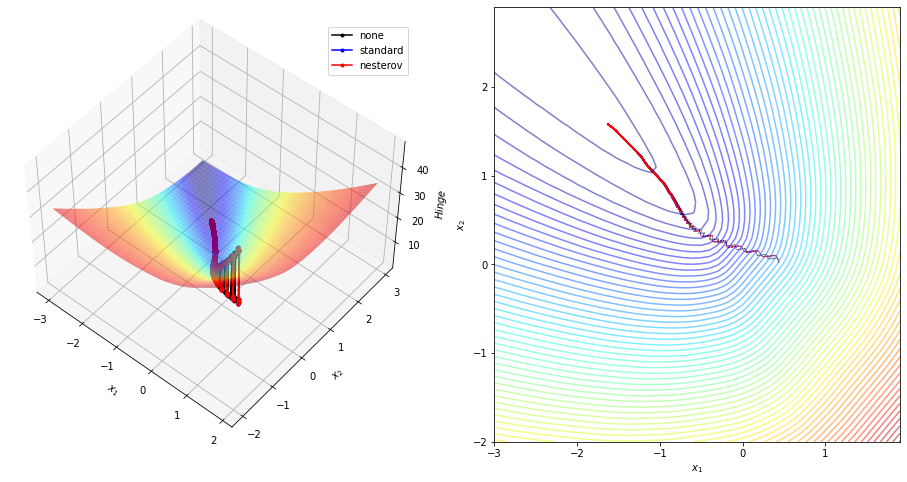

In [12]:
grid = GridSearchCV(PrimalSVC(loss=hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, momentum=0.4, 
                              momentum_type='nesterov', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

hinge_loss_opt = plot_trajectory_optimization(hinge_loss_opt, grid.best_estimator_.optimizer, 
                                              color='r', label='nesterov')
hinge_loss_opt.savefig('./tex/img/svc_hinge_loss.png')
hinge_loss_opt

In [13]:
nesterov_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.301714     0.970     229    48
                10   0.345403     0.985     288    16
                100  0.159904     0.985     130    11

In [14]:
custom_primal_svc_hinge_cv_results = none_primal_svc_hinge_cv_results.append(
    standard_primal_svc_hinge_cv_results).append(
    nesterov_primal_svc_hinge_cv_results)
custom_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.399575     0.970     314    53
                10   0.480145     0.985     384    19
                100  0.258918     0.980     207    10
       standard 1    0.305286     0.970     229    48
                10   0.350044     0.985     296    16
                100  0.204298     0.980     124    11
       nesterov 1    0.301714     0.970     229    48
                10   0.345403     0.985     288    16
                100  0.159904     0.985     130    11

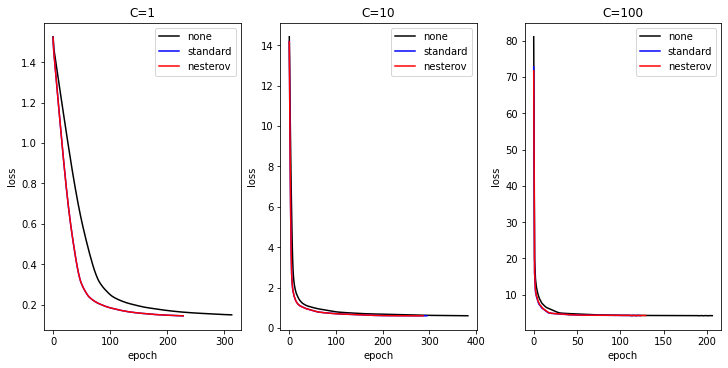

In [15]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(10, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('epoch')
        loss.set_ylabel('loss')
        loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/svc_hinge_loss_history.png')

In [16]:
grid = GridSearchCV(SkLinearSVC(loss='hinge', random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [17]:
liblinear_primal_svc_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.001039     0.985     332    15
                   10   0.001164     0.985     554     5
                   100  0.001599     0.985    1000     7

In [18]:
primal_svc_hinge_cv_results = custom_primal_svc_hinge_cv_results.append(liblinear_primal_svc_hinge_cv_results)
primal_svc_hinge_cv_results.to_latex('./tex/experiments/primal_svc_hinge.tex', 
                                     caption='SVC Primal formulation results with Hinge loss', 
                                     label='primal_svc_hinge_cv_results', position='H')
primal_svc_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.399575     0.970     314    53
                   10   0.480145     0.985     384    19
                   100  0.258918     0.980     207    10
          standard 1    0.305286     0.970     229    48
                   10   0.350044     0.985     296    16
                   100  0.204298     0.980     124    11
          nesterov 1    0.301714     0.970     229    48
                   10   0.345403     0.985     288    16
                   100  0.159904     0.985     130    11
liblinear -        1    0.001039     0.985     332    15
                   10   0.001164     0.985     554     5
                   100  0.001599     0.985    1000     7

### Dual formulations

In [26]:
from optiml.ml.svm import DualSVC
from optiml.ml.svm.kernels import linear, PolyKernel, GaussianKernel
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import AdaGrad

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [7]:
import re
from io import StringIO
from wurlitzer import pipes, STDOUT


class SklSVC(SVC):

    def fit(self, X, y, sample_weight=None):
        out = StringIO()
        with pipes(stdout=out, stderr=STDOUT):
            super().fit(X, y, sample_weight)
        self.n_iter_ = int(re.findall(r'%s(\d+)' % '#iter = ', out.getvalue())[0])
        return self

In [29]:
train_loss_history = defaultdict(lambda: defaultdict(dict))

def dual_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history') and svc.optimizer.iter > 0:
        dual = 'qp' if svc.fit_intercept else 'bcqp'
        train_loss_history[dual][svc.kernel.__class__.__name__][svc.C] = svc.train_loss_history
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SklSVC) else (svc.iter if isinstance(svc.optimizer, str) 
                                                                   else svc.optimizer.iter) + 1,  # starts from 0
            'n_sv': len(svc.support_)}

#### Wolfe Dual

##### Linear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


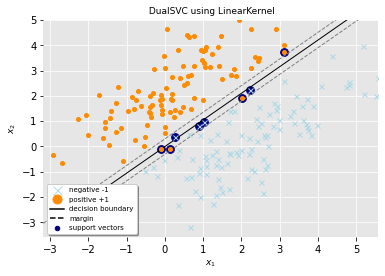

In [25]:
grid = GridSearchCV(DualSVC(kernel=linear,
                    param_grid={'C': [1, 10, 100],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

plot_svm_hyperplane(grid.best_estimator_, lin_X, lin_y)
plt.savefig('./tex/img/linear_dual_svc_hyperplane.png')

In [26]:
custom_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
custom_linear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
custom_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
custom_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
cvxopt 1    0.020693     0.980      10    17
       10   0.023231     0.980      10    11
       100  0.064602     0.985      10     8
smo    1    0.052323     0.980      62    17
       10   0.091658     0.980     295    10
       100  0.137948     0.985     399     8

In [27]:
grid = GridSearchCV(SklSVC(kernel='linear', verbose=True),  # `verbose=True` to capture n_iter
                    param_grid={'C': [1, 10, 100]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits
[LibSVM]

In [28]:
libsvm_linear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_linear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_linear_dual_svc_cv_results.set_index(['solver', 'C'], inplace=True)
libsvm_linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
libsvm 1    0.002719     0.985     243    17
       10   0.002529     0.985     194    10
       100  0.002797     0.985    1602     8

In [29]:
linear_dual_svc_cv_results = custom_linear_dual_svc_cv_results.append(libsvm_linear_dual_svc_cv_results)
linear_dual_svc_cv_results.sort_values(['solver'], ascending=False, inplace=True)
linear_dual_svc_cv_results.to_latex('./tex/experiments/linear_dual_svc.tex', 
                                    caption='Linear SVC Wolfe Dual formulation results with Hinge loss', 
                                    label='linear_dual_svc_cv_results', position='H')
linear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver C                                    
smo    1    0.052323     0.980      62    17
       10   0.091658     0.980     295    10
       100  0.137948     0.985     399     8
libsvm 1    0.002719     0.985     243    17
       10   0.002529     0.985     194    10
       100  0.002797     0.985    1602     8
cvxopt 1    0.020693     0.980      10    17
       10   0.023231     0.980      10    11
       100  0.064602     0.985      10     8

##### Nonlinear

Fitting 1 folds for each of 6 candidates, totalling 6 fits


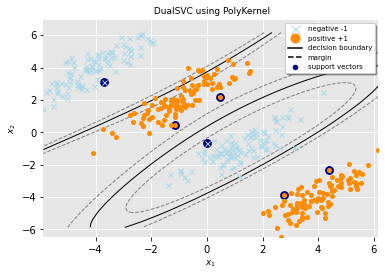

In [34]:
grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/poly_dual_svc_hyperplane.png')

In [35]:
poly_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
poly_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
poly_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
poly_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.208703    0.6775      10    31
              10   0.194188    0.9475      10    10
              100  0.228154    0.9775      10     6
smo    poly   1    0.262513    0.6825     143    30
              10   0.197470    0.9475      65    10
              100  0.140720    0.9775      38     6

Fitting 1 folds for each of 6 candidates, totalling 6 fits


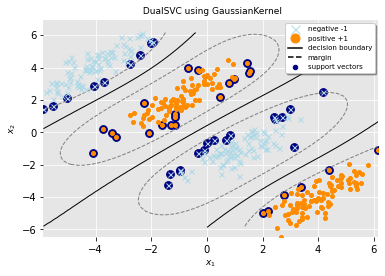

In [36]:
grid = GridSearchCV(DualSVC(),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [GaussianKernel(gamma='scale')],
                                'optimizer': ['smo', 'cvxopt']},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

plot_svm_hyperplane(grid.best_estimator_, nonlin_X, nonlin_y)
plt.savefig('./tex/img/gaussian_dual_svc_hyperplane.png')

In [37]:
rbf_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
rbf_nonlinear_dual_svc_cv_results.sort_values(['solver'], inplace=True)
rbf_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
rbf_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt rbf    1    0.177948       1.0      10    50
              10   0.239361       1.0      10    19
              100  0.206783       1.0      10    17
smo    rbf    1    0.289481       1.0      66    51
              10   0.143812       1.0      38    13
              100  0.196509       1.0      56    12

In [38]:
custom_nonlinear_dual_svc_cv_results = poly_nonlinear_dual_svc_cv_results.append(rbf_nonlinear_dual_svc_cv_results)
custom_nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], inplace=True)
custom_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
cvxopt poly   1    0.208703    0.6775      10    31
              10   0.194188    0.9475      10    10
              100  0.228154    0.9775      10     6
       rbf    1    0.177948    1.0000      10    50
              10   0.239361    1.0000      10    19
              100  0.206783    1.0000      10    17
smo    poly   1    0.262513    0.6825     143    30
              10   0.197470    0.9475      65    10
              100  0.140720    0.9775      38     6
       rbf    1    0.289481    1.0000      66    51
              10   0.143812    1.0000      38    13
              100  0.196509    1.0000      56    12

In [39]:
grid = GridSearchCV(SklSVC(verbose=True),  # `verbose=True` to capture n_iter
                    param_grid=[{'C': [1, 10, 100],
                                 'kernel': ['poly'],
                                 'degree': [3],
                                 'coef0': [1],
                                 'gamma': ['scale']},
                                {'C': [1, 10, 100],
                                 'kernel': ['rbf'],
                                 'gamma': ['scale']}],
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits
[LibSVM]

In [40]:
libsvm_nonlinear_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
libsvm_nonlinear_dual_svc_cv_results.insert(0, 'solver', 'libsvm')
libsvm_nonlinear_dual_svc_cv_results.sort_values(['kernel'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results.set_index(['solver', 'kernel', 'C'], inplace=True)
libsvm_nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
libsvm poly   1    0.005542       1.0     233    30
              10   0.004144       1.0     118    10
              100  0.004042       1.0      88     6
       rbf    1    0.005162       1.0     252    50
              10   0.003994       1.0     134    13
              100  0.005558       1.0     182    12

In [41]:
nonlinear_dual_svc_cv_results = custom_nonlinear_dual_svc_cv_results.append(libsvm_nonlinear_dual_svc_cv_results)
nonlinear_dual_svc_cv_results.sort_values(['solver', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_dual_svc.tex', 
                                       caption='Nonlinear SVC Wolfe Dual formulation results with Hinge loss', 
                                       label='nonlinear_dual_svc_cv_results', position='H')
nonlinear_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
solver kernel C                                    
smo    poly   1    0.262513    0.6825     143    30
              10   0.197470    0.9475      65    10
              100  0.140720    0.9775      38     6
       rbf    1    0.289481    1.0000      66    51
              10   0.143812    1.0000      38    13
              100  0.196509    1.0000      56    12
libsvm poly   1    0.005542    1.0000     233    30
              10   0.004144    1.0000     118    10
              100  0.004042    1.0000      88     6
       rbf    1    0.005162    1.0000     252    50
              10   0.003994    1.0000     134    13
              100  0.005558    1.0000     182    12
cvxopt poly   1    0.208703    0.6775      10    31
              10   0.194188    0.9475      10    10
              100  0.228154    0.9775      10     6
       rbf    1    0.177948    1.0000      10    50
              10   0.239361    1.0000      10    19
              100  0.206783    1.0000      10    17

#### Lagrangian Dual

##### Linear

In [30]:
grid = GridSearchCV(DualSVC(kernel=linear, optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 6 candidates, totalling 6 fits


In [31]:
linear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
linear_lagrangian_dual_svc_cv_results.sort_values(['dual'], ascending=False, inplace=True)
linear_lagrangian_dual_svc_cv_results.set_index(['dual', 'C'], inplace=True)
linear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/linear_lagrangian_dual_svc.tex', 
                                               caption='Linear SVC Lagrangian Dual formulation results with Hinge loss', 
                                               label='linear_lagrangian_dual_svc_cv_results', position='H')
linear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual C                                    
qp   1    0.021188     0.985       1   195
     10   0.007776     0.985       1   195
     100  0.007696     0.985       1   195
bcqp 1    0.008790     0.985       1   194
     10   0.008028     0.985       1   194
     100  0.008192     0.985       1   194

##### Nonlinear

In [32]:
grid = GridSearchCV(DualSVC(optimizer=AdaGrad, learning_rate=0.001),
                    param_grid={'C': [1, 10, 100],
                                'kernel': [PolyKernel(degree=3, coef0=1, gamma='scale'), 
                                           GaussianKernel(gamma='scale')],
                                'fit_intercept': [True, False]},
                    scoring=dual_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(nonlin_X, nonlin_y)

Fitting 1 folds for each of 12 candidates, totalling 12 fits


In [33]:
nonlinear_lagrangian_dual_svc_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nonlinear_lagrangian_dual_svc_cv_results.sort_values(['dual', 'kernel'], ascending=[False, True], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.set_index(['dual', 'kernel', 'C'], inplace=True)
nonlinear_lagrangian_dual_svc_cv_results.to_latex('./tex/experiments/nonlinear_lagrangian_dual_svc.tex', 
                                                  caption='Nonlinear SVC Lagrangian Dual formulation results with Hinge loss', 
                                                  label='nonlinear_lagrangian_dual_svc_cv_results', position='H')
nonlinear_lagrangian_dual_svc_cv_results

fit_time  accuracy  n_iter  n_sv
dual kernel C                                    
qp   poly   1    0.070955     0.640       3   316
            10   0.029068     0.640       3   316
            100  0.033551     0.640       3   316
     rbf    1    0.159082     0.860       9   307
            10   0.105469     0.860       9   307
            100  0.129717     0.860       9   307
bcqp poly   1    0.904675     0.635     222   317
            10   0.871326     0.635     222   317
            100  0.771419     0.635     222   317
     rbf    1    0.067391     1.000       1   399
            10   0.059650     1.000       1   399
            100  0.064887     1.000       1   399

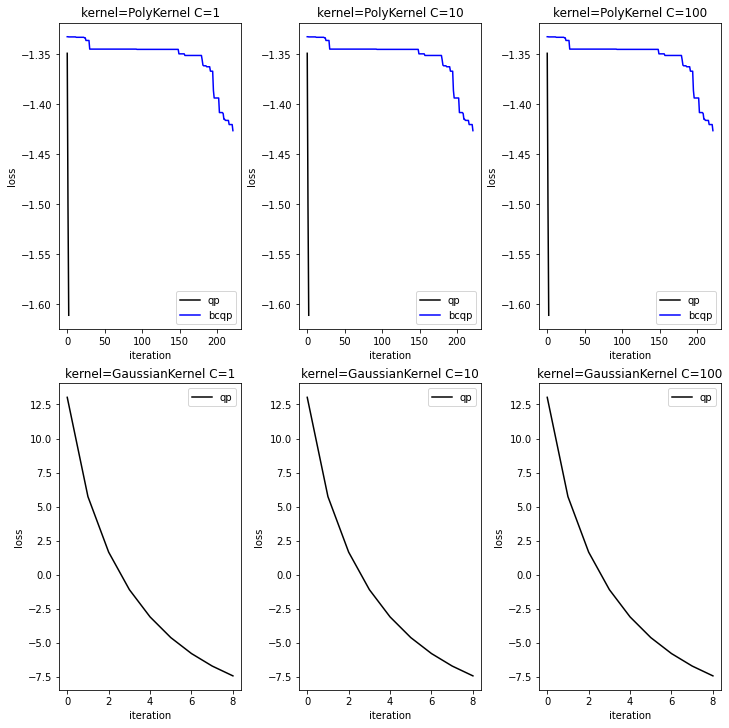

In [35]:
colors = {'qp': 'k',
          'bcqp': 'b'}
axes = plt.figure(figsize=(10, 10), constrained_layout=True).subplots(2, 3)  # figsize (10, 15) and subplots (3, 3)
for dual, _dict1 in train_loss_history.items():
    for (kernel, _dict2), row_ax in zip(_dict1.items(), axes):
        for (C, history), loss in zip(_dict2.items(), row_ax):
            loss.plot(history, color=colors[dual])
            loss.set_title('kernel={} C={:d}'.format(kernel, C))
            loss.set_xlabel('iteration')
            loss.set_ylabel('loss')
            loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/lagrangian_dual_svc_loss_history.png')

## Squared Hinge loss

### Primal formulation

In [69]:
from optiml.ml.svm import PrimalSVC
from optiml.ml.svm.losses import squared_hinge
from optiml.ml.utils import plot_svm_hyperplane

from optiml.opti.unconstrained.stochastic import StochasticGradientDescent
from optiml.opti.utils import plot_surface_contour, plot_trajectory_optimization

from sklearn.svm import LinearSVC as SkLinearSVC
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

In [92]:
train_loss_history = defaultdict(dict)

def primal_accuracy_scorer(svc, X, y):
    if hasattr(svc, 'train_loss_history'):
        train_loss_history[svc.momentum_type][svc.C] = svc.train_loss_history
    return {'accuracy': svc.score(X, y), 
            'n_iter': svc.n_iter_ if isinstance(svc, SkLinearSVC) else svc.optimizer.epoch + 1,  # starts from 0
            'n_sv': len(np.argwhere(np.abs(svc.decision_function(X)) <= 1).ravel())}

Fitting 1 folds for each of 3 candidates, totalling 3 fits


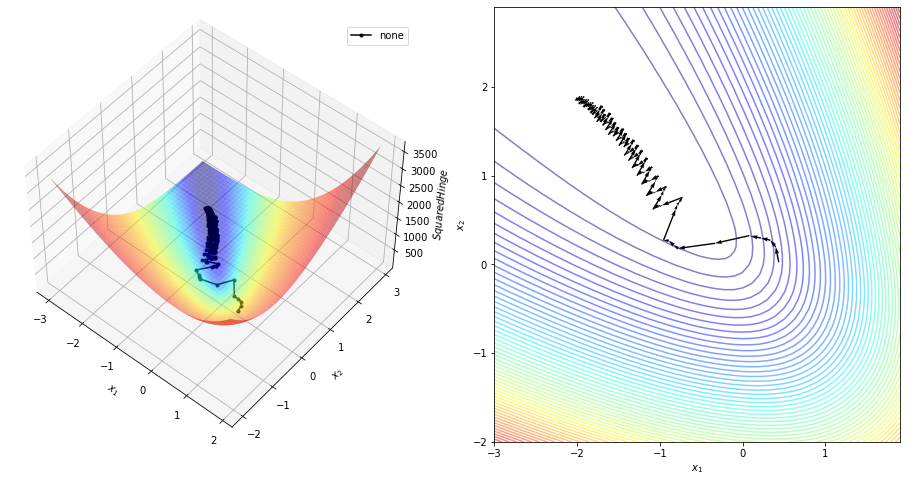

In [93]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='none', batch_size=20, early_stopping=True, random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss = plot_surface_contour(grid.best_estimator_.loss, x_min=-3, x_max=2, y_min=-2, y_max=3)
squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss, grid.best_estimator_.optimizer, 
                                                      color='k', label='none')

In [94]:
none_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
none_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
none_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'none')
none_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
none_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.328431     0.975     155    49
                10   0.180572     0.980     120    24
                100  0.055479     0.985      31    15

Fitting 1 folds for each of 3 candidates, totalling 3 fits


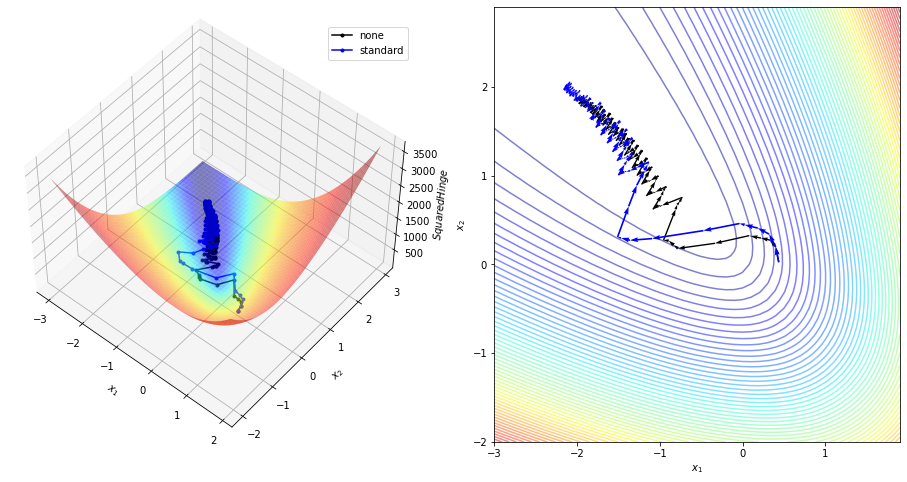

In [95]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='standard', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='b', label='standard')
squared_hinge_loss_opt

In [96]:
standard_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
standard_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
standard_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'standard')
standard_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
standard_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    standard 1    0.259427     0.975     114    45
                10   0.125017     0.980      74    24
                100  0.039369     0.985      22    11

Fitting 1 folds for each of 3 candidates, totalling 3 fits


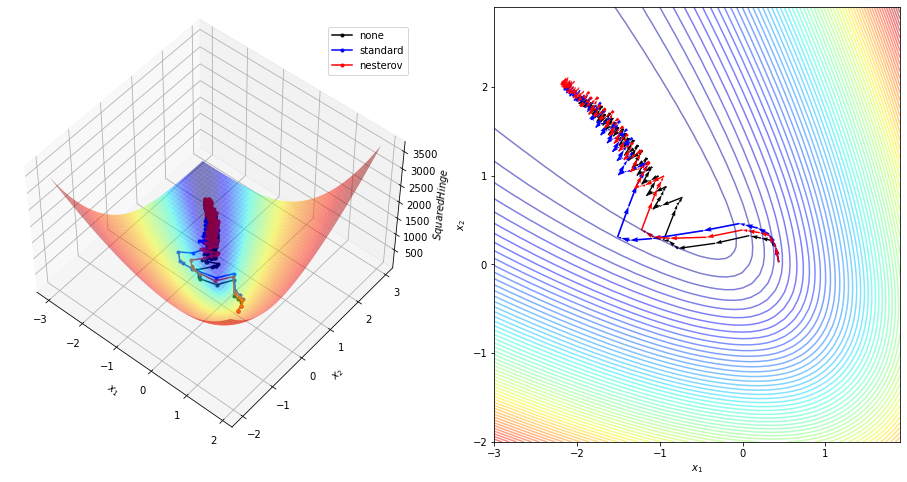

In [97]:
grid = GridSearchCV(PrimalSVC(loss=squared_hinge, optimizer=StochasticGradientDescent, learning_rate=0.001, 
                              momentum_type='nesterov', momentum=0.4, batch_size=20, early_stopping=True, 
                              random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=1,  # 'train_loss_history' is not thread safe
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

squared_hinge_loss_opt = plot_trajectory_optimization(squared_hinge_loss_opt, grid.best_estimator_.optimizer, 
                                                      color='r', label='nesterov')
squared_hinge_loss_opt.savefig('./tex/img/svc_squared_hinge_loss.png')
squared_hinge_loss_opt

In [98]:
nesterov_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
nesterov_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'sgd')
nesterov_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', 'nesterov')
nesterov_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
nesterov_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    nesterov 1    0.316861     0.970     133    40
                10   0.111990     0.980      72    23
                100  0.042542     0.985      27    10

In [99]:
custom_primal_svc_squared_hinge_cv_results = none_primal_svc_squared_hinge_cv_results.append(
    standard_primal_svc_squared_hinge_cv_results).append(
    nesterov_primal_svc_squared_hinge_cv_results)
custom_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver momentum C                                    
sgd    none     1    0.328431     0.975     155    49
                10   0.180572     0.980     120    24
                100  0.055479     0.985      31    15
       standard 1    0.259427     0.975     114    45
                10   0.125017     0.980      74    24
                100  0.039369     0.985      22    11
       nesterov 1    0.316861     0.970     133    40
                10   0.111990     0.980      72    23
                100  0.042542     0.985      27    10

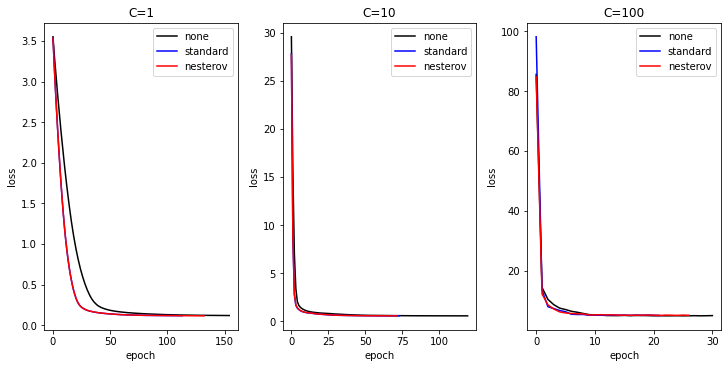

In [100]:
colors = {'none': 'k',
          'standard': 'b',
          'nesterov': 'r'}
axes = plt.figure(figsize=(10, 5), constrained_layout=True).subplots(1, 3)
for momentum, _dict in train_loss_history.items():
    for (C, history), loss in zip(_dict.items(), axes):
        loss.plot(history, color=colors[momentum])
        loss.set_title('C={:d}'.format(C))
        loss.set_xlabel('epoch')
        loss.set_ylabel('loss')
        loss.legend(colors.keys()).get_frame().set_facecolor('white')
plt.savefig('./tex/img/svc_squared_hinge_loss_history.png')

In [101]:
grid = GridSearchCV(SkLinearSVC(loss='squared_hinge', random_state=2),
                    param_grid={'C': [1, 10, 100]},
                    scoring=primal_accuracy_scorer,
                    cv=[(slice(None), slice(None))],  # no cross validation https://stackoverflow.com/a/44682305/2202107
                    n_jobs=-1,  # use all processors
                    refit='accuracy',  # refit the best model (wrt accuracy) on the full development set
                    return_train_score=True,
                    verbose=True).fit(lin_X, lin_y)

Fitting 1 folds for each of 3 candidates, totalling 3 fits


In [102]:
liblinear_primal_svc_squared_hinge_cv_results = filter_svc_cv_results(pd.DataFrame(grid.cv_results_))
liblinear_primal_svc_squared_hinge_cv_results.insert(0, 'solver', 'liblinear')
liblinear_primal_svc_squared_hinge_cv_results.insert(1, 'momentum', '-')
liblinear_primal_svc_squared_hinge_cv_results.set_index(['solver', 'momentum', 'C'], inplace=True)
liblinear_primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
liblinear -        1    0.001615      0.98     556    25
                   10   0.002271      0.98    1000    19
                   100  0.002238      0.98    1000    27

In [81]:
primal_svc_squared_hinge_cv_results = custom_primal_svc_squared_hinge_cv_results.append(liblinear_primal_svc_squared_hinge_cv_results)
primal_svc_squared_hinge_cv_results.to_latex('./tex/experiments/primal_svc_squared_hinge.tex', 
                                             caption='SVC Primal formulation results with Squared Hinge loss', 
                                             label='primal_svc_squared_hinge_cv_results', position='H')
primal_svc_squared_hinge_cv_results

fit_time  accuracy  n_iter  n_sv
solver    momentum C                                    
sgd       none     1    0.266864     0.970     118    49
                   10   0.057214     0.975      38    31
                   100  0.020525     0.975      11    18
          standard 1    0.218742     0.970      86    44
                   10   0.042822     0.975      24    29
                   100  0.023315     0.975      12    14
          nesterov 1    0.223442     0.970      80    46
                   10   0.048704     0.975      25    29
                   100  0.018014     0.975      10    15
liblinear -        1    0.006113     0.980     500    42
                   10   0.010983     0.975    1000    38
                   100  0.010572     0.975    1000    36